In [1]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
poly,
ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

In [2]:
from pygam import (s as s_gam,
l as l_gam,
f as f_gam,
LinearGAM,
LogisticGAM)
from ISLP.transforms import (BSpline,
NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
degrees_of_freedom,
plot as plot_gam,
anova as anova_gam)

In [3]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

In [4]:
poly_age = MS([poly('age', degree=4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [5]:
age_grid = np.linspace(age.min(),
age.max(),
100)
age_df = pd.DataFrame({'age': age_grid})

In [10]:
def plot_wage_fit(age_df,
    basis,
    title):
    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(age,
    y,
             facecolor='gray',
    alpha=0.5)
    for val, ls in zip([preds.predicted_mean ,
        bands[:,0],
        bands[:,1]],
        ['b','r--','r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)
        ax.set_title(title, fontsize=20)
        ax.set_xlabel('Age', fontsize=20)
        ax.set_ylabel('Wage', fontsize=20);
        return ax  

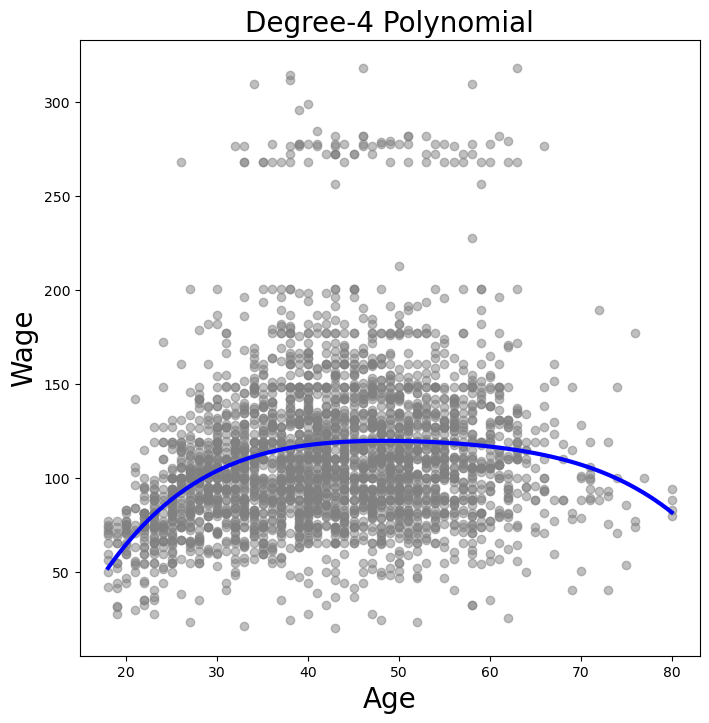

In [11]:
plot_wage_fit(age_df,
poly_age,
'Degree-4 Polynomial');

In [12]:
models = [MS([poly('age', degree=d)])
for d in range(1, 6)]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit()
for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [13]:
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [14]:
(-11.983)**2

143.59228900000002

In [15]:
models = [MS(['education', poly('age', degree=d)])
for d in range(1, 4)]
XEs = [model.fit_transform(Wage)
for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in XEs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2997.0,3.902335e+06,0.0,NaN,NaN,NaN
1,2996.0,3.759472e+06,1.0,142862.701185,113.991883,3.838075e-26
2,2995.0,3.753546e+06,1.0,5926.207070,4.728593,2.974318e-02


In [16]:
X = poly_age.transform(Wage)
high_earn = Wage['high_earn'] = y > 250 # shorthand
glm = sm.GLM(y > 250,
X,
family=sm.families.Binomial())
B = glm.fit()
summarize(B)

,coef,std err,z,P>|z|
intercept,-4.3012,0.345,-12.457,0.000
"poly(age, degree=4)[0]",71.9642,26.133,2.754,0.006
"poly(age, degree=4)[1]",-85.7729,35.929,-2.387,0.017
"poly(age, degree=4)[2]",34.1626,19.697,1.734,0.083
"poly(age, degree=4)[3]",-47.4008,24.105,-1.966,0.049


In [17]:
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

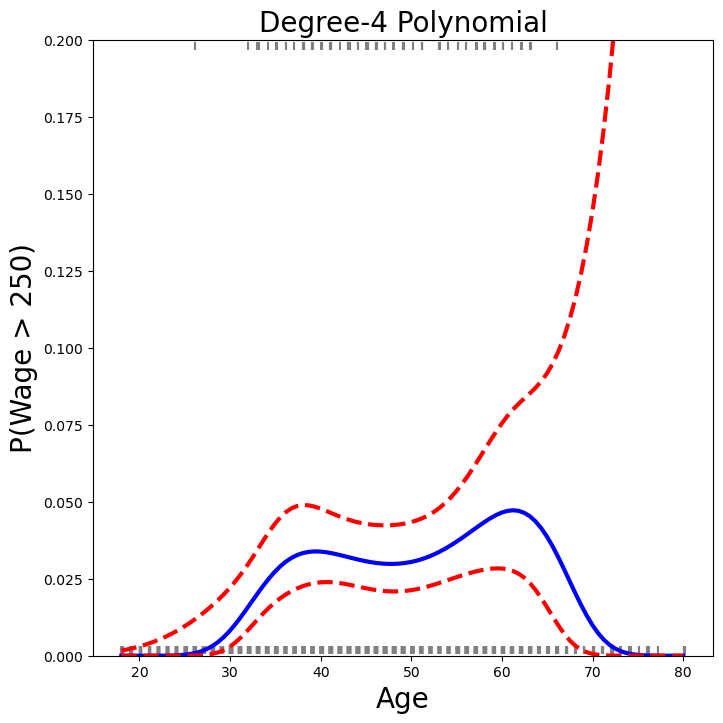

In [19]:
fig, ax = subplots(figsize=(8,8))
rng = np.random.default_rng(0)
ax.scatter(age +
0.2 * rng.uniform(size=y.shape[0]),
np.where(high_earn, 0.198, 0.002),
fc='gray',
marker='|')
for val, ls in zip([preds.predicted_mean ,
    bands[:,0],
    bands[:,1]],
    ['b','r--','r--']):
    ax.plot(age_df.values, val, ls, linewidth=3)
    ax.set_title('Degree-4 Polynomial', fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylim([0,0.2])
    ax.set_ylabel('P(Wage > 250)', fontsize=20);

In [20]:
 cut_age = pd.qcut(age, 4)
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


In [21]:
bs_ = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape

(3000, 7)

In [22]:
 bs_age = MS([bs('age', internal_knots=[25,40,60])])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


In [23]:
bs_age = MS([bs('age',
internal_knots=[25,40,60],
name='bs(age)')])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
bs(age)[0],3.9805,12.538,0.317,0.751
bs(age)[1],44.6310,9.626,4.636,0.000
bs(age)[2],62.8388,10.755,5.843,0.000
bs(age)[3],55.9908,10.706,5.230,0.000
bs(age)[4],50.6881,14.402,3.520,0.000
bs(age)[5],16.6061,19.126,0.868,0.385


In [24]:
BSpline(df=6).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

In [25]:
bs_age0 = MS([bs('age',
df=3,
degree=0)]).fit(Wage)
Xbs0 = bs_age0.transform(Wage)
summarize(sm.OLS(y, Xbs0).fit())

,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


In [26]:
 ns_age = MS([ns('age', df=5)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


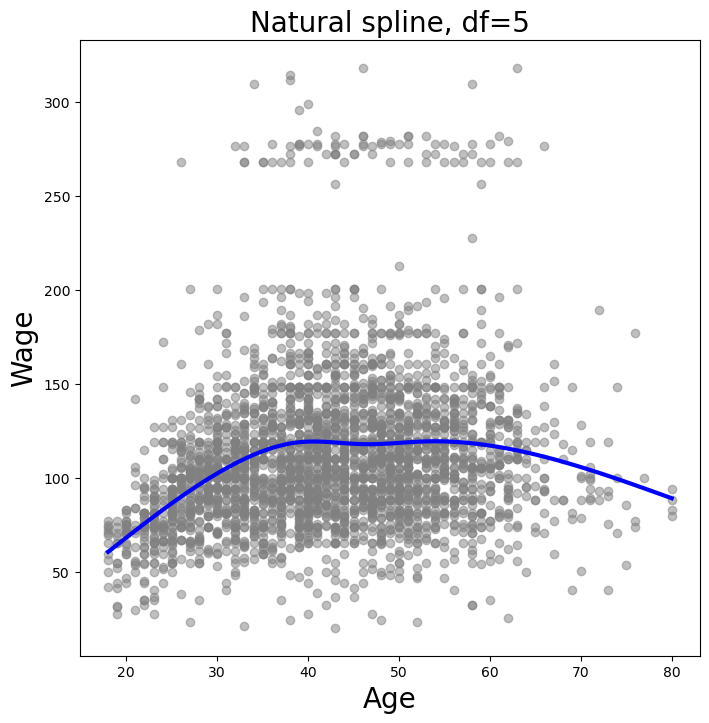

In [27]:
plot_wage_fit(age_df,
ns_age,
'Natural spline, df=5');

In [28]:
 X_age = np.asarray(age).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_age, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Dismas\AppData\Local\Temp\ipykernel_2988\2750759779.py:11: SyntaxWarning: invalid escape sequence '\l'
  ax.legend(title='$\lambda$');


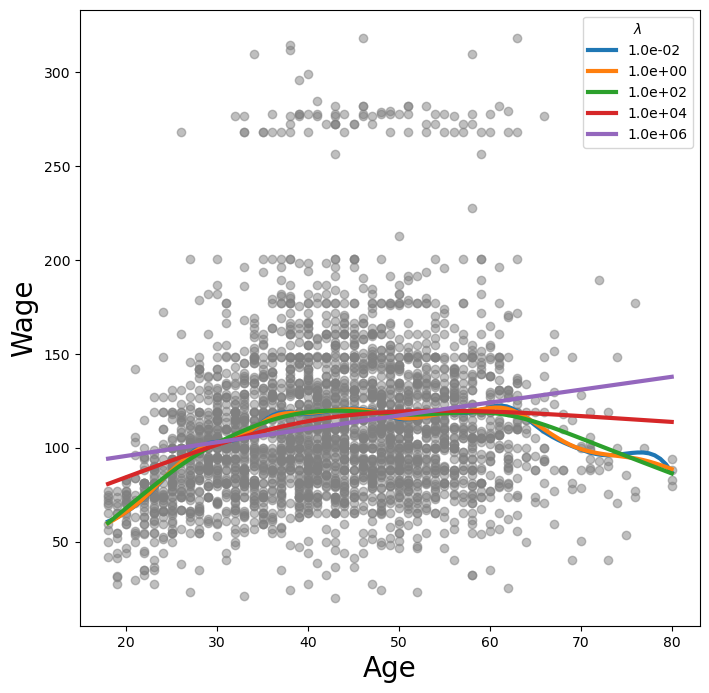

In [30]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for lam in np.logspace(-2, 6, 5):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, y)
    ax.plot(age_grid,
    gam.predict(age_grid),
    label='{:.1e}'.format(lam),
    linewidth=3)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20);
    ax.legend(title='$\lambda$');

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


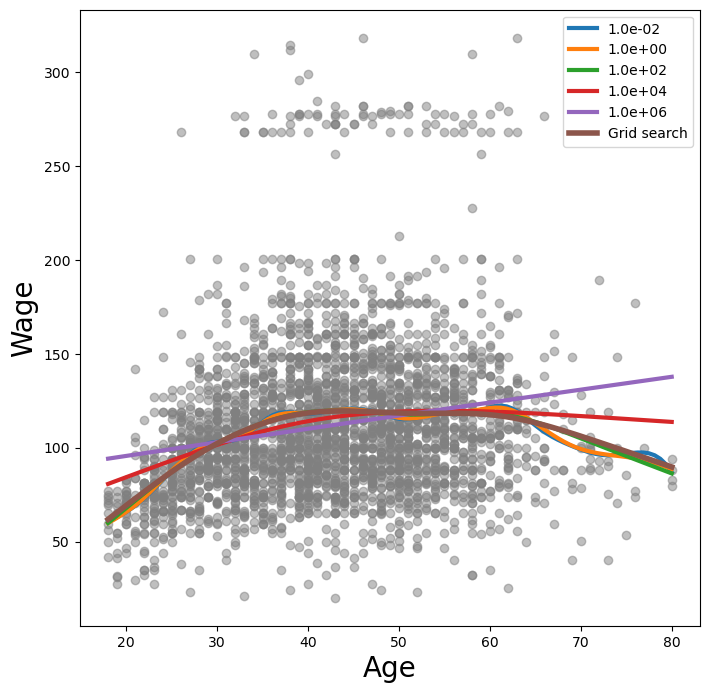

In [31]:
gam_opt = gam.gridsearch(X_age, y)
ax.plot(age_grid,
gam_opt.predict(age_grid),
label='Grid search',
linewidth=4)
ax.legend()
fig

In [32]:
age_term = gam.terms[0]
lam_4 = approx_lam(X_age, age_term, 4)
age_term.lam = lam_4
degrees_of_freedom(X_age, age_term)

4.0000001000025565

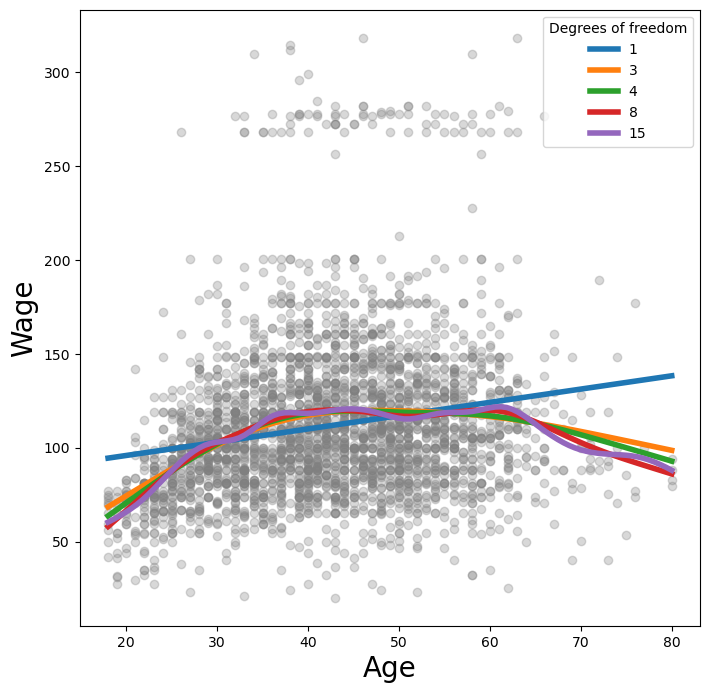

In [35]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(X_age,
y,
           facecolor='gray',
alpha=0.3)
for df in [1,3,4,8,15]:
    lam = approx_lam(X_age, age_term, df+1)
    age_term.lam = lam
    gam.fit(X_age, y)
    ax.plot(age_grid,
    gam.predict(age_grid),
    label='{:d}'.format(df),
    linewidth=4)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20);
    ax.legend(title='Degrees of freedom');

In [36]:
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(Wage['year'])
Xs = [ns_age.transform(age),
ns_year.transform(Wage['year']),
pd.get_dummies(Wage['education']).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()

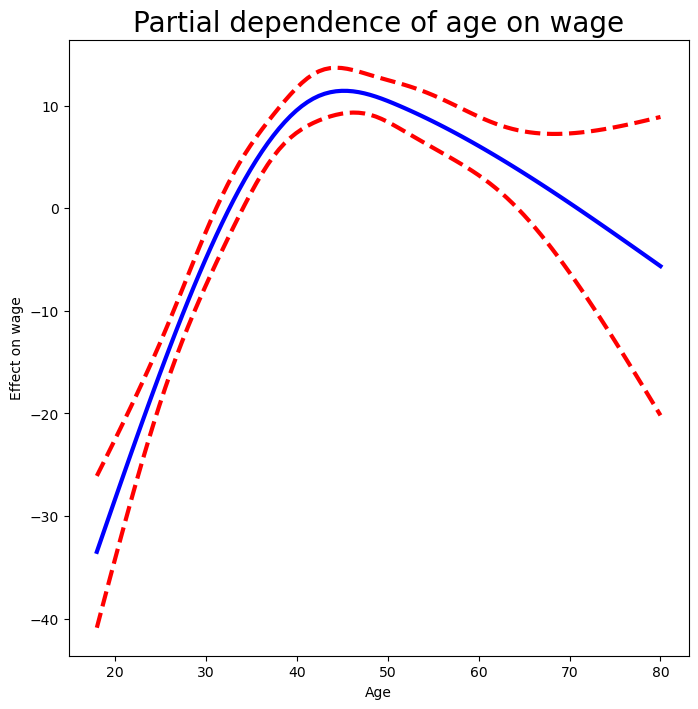

In [37]:
age_grid = np.linspace(age.min(),
age.max(),
100)
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None,:]
X_age_bh[:,:4] = ns_age.transform(age_grid)
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(age_grid, partial_age, 'b', linewidth=3)
ax.plot(age_grid, bounds_age[:,0], 'r--', linewidth=3)
ax.plot(age_grid, bounds_age[:,1], 'r--', linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize=20);

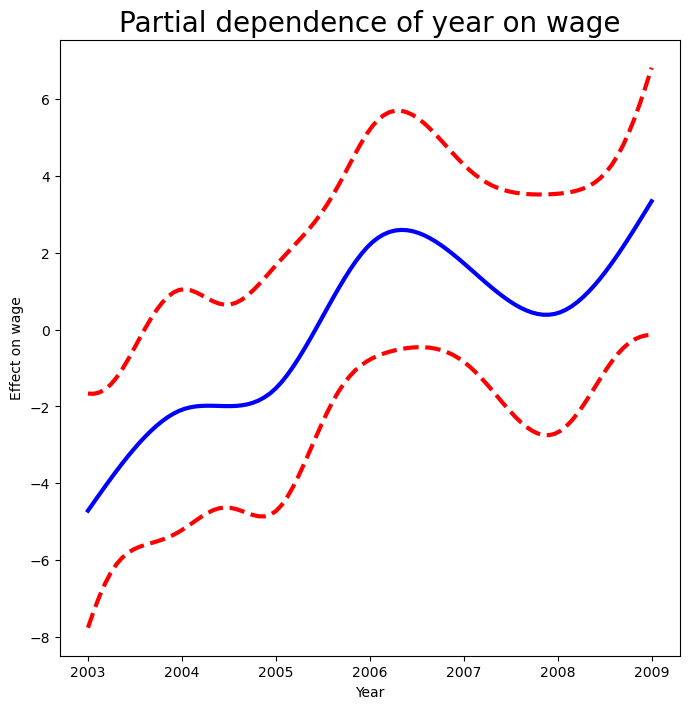

In [38]:
year_grid = np.linspace(2003, 2009, 100)
year_grid = np.linspace(Wage['year'].min(),
Wage['year'].max(),
100)
X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None,:]
X_year_bh[:,4:9] = ns_year.transform(year_grid)
preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha=0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year -= center
bounds_year -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(year_grid, partial_year , 'b', linewidth=3)
ax.plot(year_grid, bounds_year[:,0], 'r--', linewidth=3)
ax.plot(year_grid, bounds_year[:,1], 'r--', linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20);

In [39]:
gam_full = LinearGAM(s_gam(0) +
s_gam(1, n_splines=7) +
f_gam(2, lam=0))
Xgam = np.column_stack([age,
Wage['year'],
Wage['education'].cat.codes])
gam_full = gam_full.fit(Xgam, y)

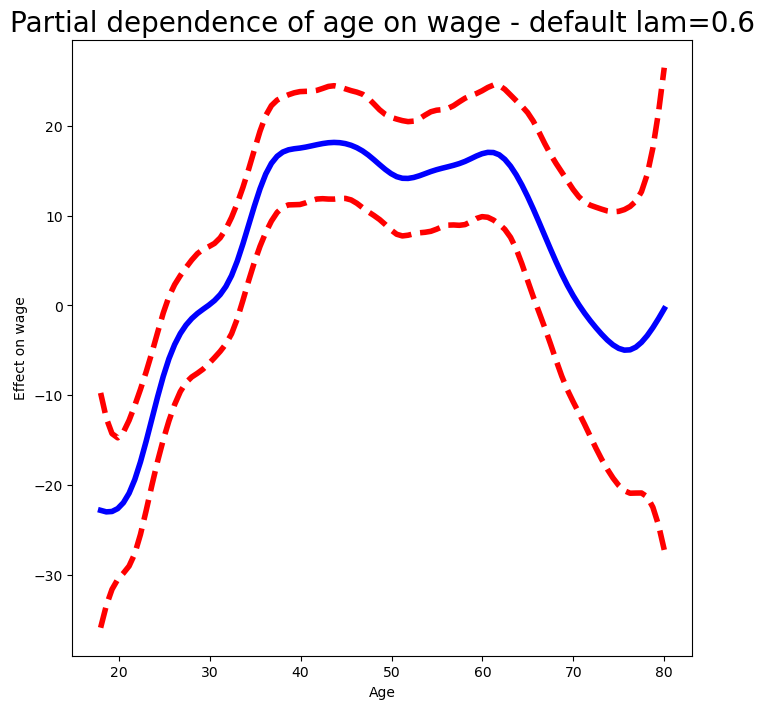

In [40]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6',
fontsize=20);

In [41]:
age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)
gam_full = gam_full.fit(Xgam, y)

Text(0.5, 1.0, 'Partial dependence of year on wage')

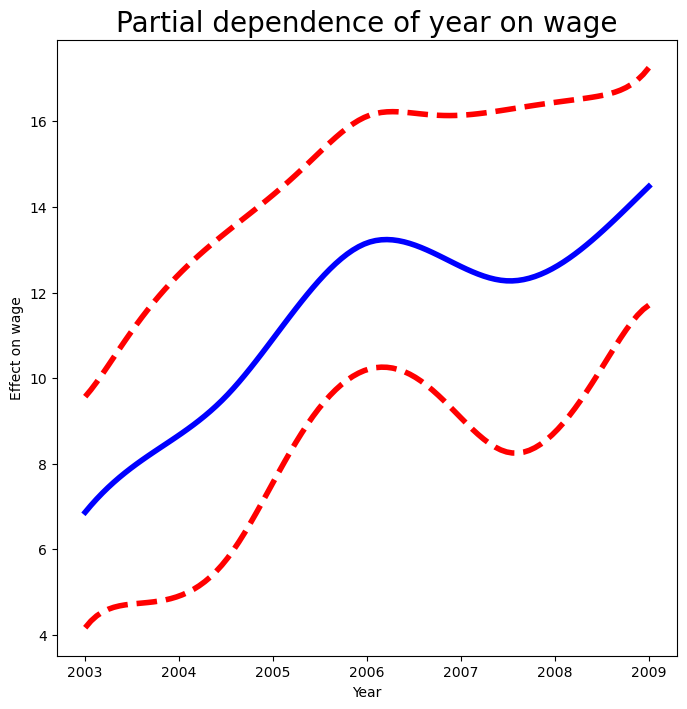

In [42]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full,
1,
ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20)

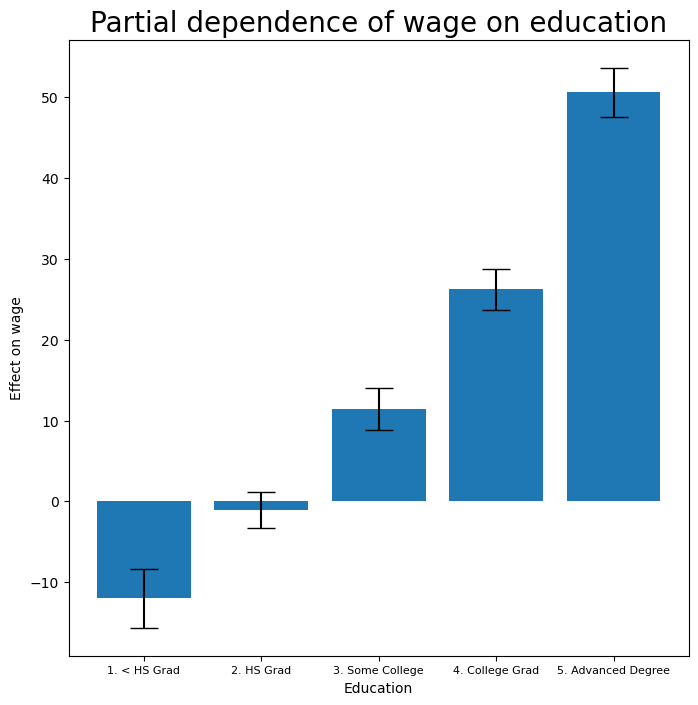

In [43]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8);

In [44]:
gam_0 = LinearGAM(age_term + f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear = LinearGAM(age_term +
l_gam(1, lam=0) +
f_gam(2, lam=0))
gam_linear.fit(Xgam, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + l(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [45]:
anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,105402.432206,2991.004005,NaN,NaN,NaN,NaN
1,105134.624170,2990.005190,267.808037,0.998815,7.625329,0.016210
2,105030.684668,2987.007254,103.939502,2.997936,0.986003,0.429637


In [46]:
gam_0 = LinearGAM(year_term +
f_gam(2, lam=0))
gam_linear = LinearGAM(l_gam(0, lam=0) +
year_term +
f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear.fit(Xgam, y)
anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,109043.809955,2991.000589,NaN,NaN,NaN,NaN
1,107295.111571,2990.000704,1748.698385,0.999884,49.737638,0.000009
2,105030.684668,2987.007254,2264.426903,2.993450,21.513266,0.000026


In [47]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.9927
Link Function:                     IdentityLink Log Likelihood:                                 -14930.261
Number of Samples:                         3000 AIC:                                            29888.5074
                                                AICc:                                            29888.648
                                                GCV:                                             1246.1129
                                                Scale:                                             35.1625
                                                Pseudo R-Squared:                                   0.2928
Feature Function                  Lam

C:\Users\Dismas\AppData\Local\Temp\ipykernel_2988\3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


In [48]:
Yhat = gam_full.predict(Xgam)

In [49]:
gam_logit = LogisticGAM(age_term +
l_gam(1, lam=0) +
f_gam(2, lam=0))
gam_logit.fit(Xgam, high_earn)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + l(1) + f(2) + intercept, tol=0.0001, verbose=False)

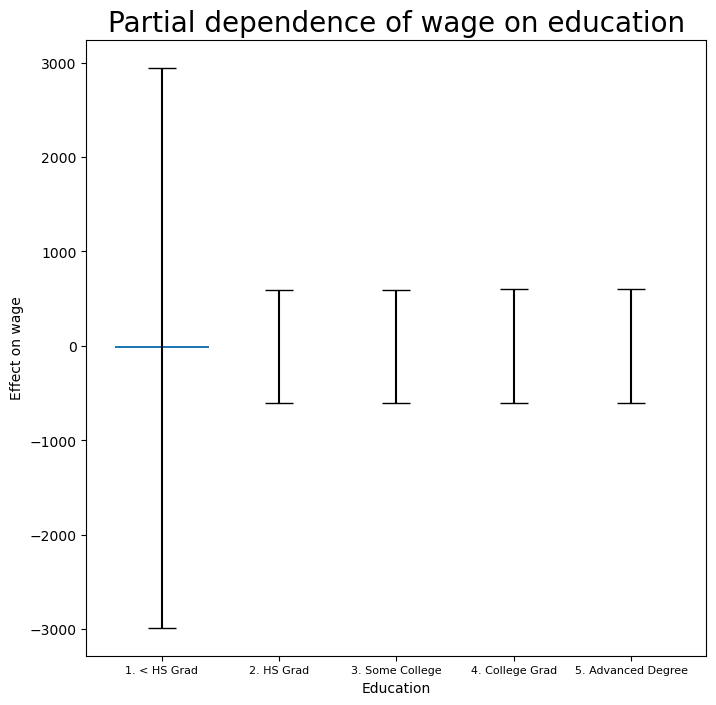

In [50]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8);

In [51]:
pd.crosstab(Wage['high_earn'], Wage['education'])

education,1. < HS Grad,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree
high_earn,,,,,
False,268,966,643,663,381
True,0,5,7,22,45


In [53]:
only_hs = Wage['education'] == '1. < HS Grad'
Wage_ = Wage.loc[~only_hs]
Xgam_ = np.column_stack([Wage_['age'],
Wage_['year'],
Wage_['education'].cat.codes -1])
high_earn_ = Wage_['high_earn']

In [54]:
gam_logit_ = LogisticGAM(age_term +
year_term +
f_gam(2, lam=0))
gam_logit_.fit(Xgam_, high_earn_)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

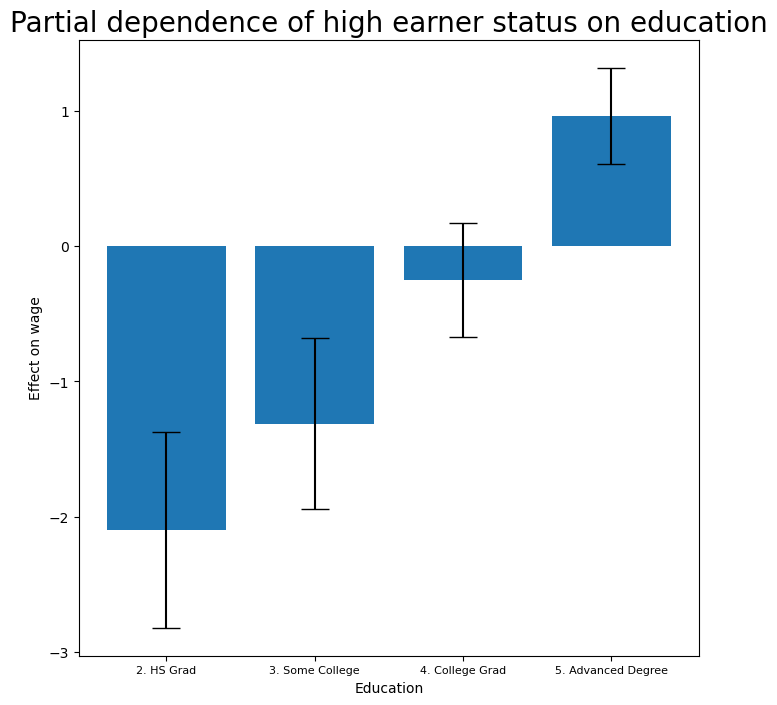

In [56]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on education', fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories[1:],
fontsize=8);

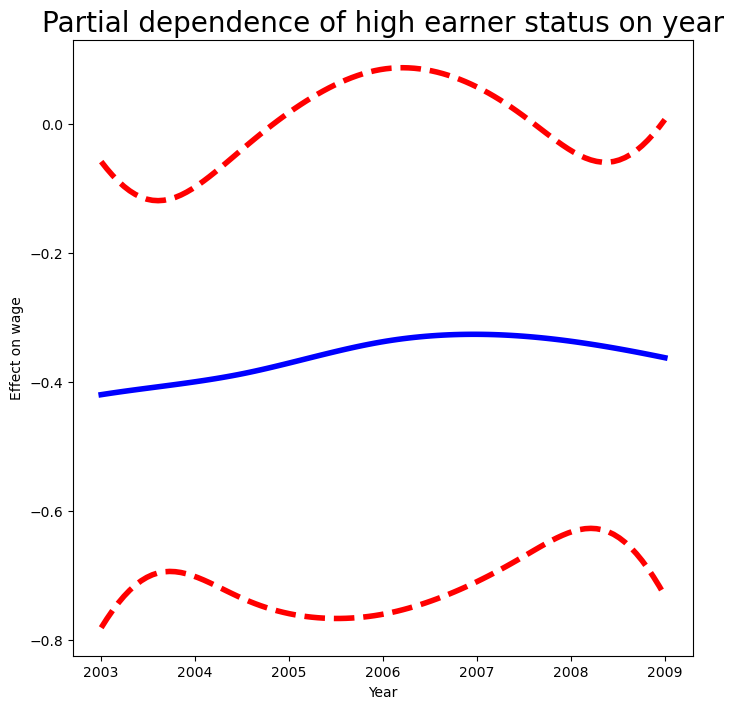

In [57]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 1)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on year',
fontsize=20);

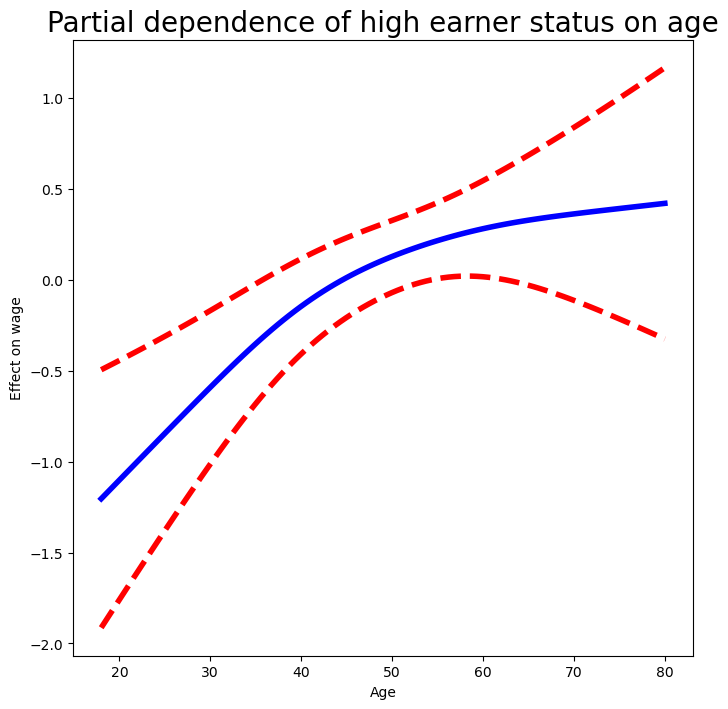

In [58]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 0)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on age',
fontsize=20);

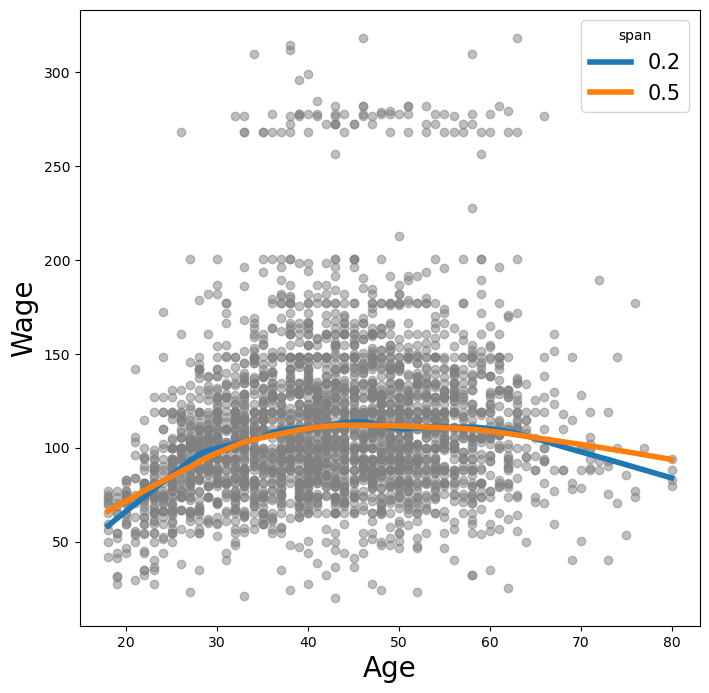

In [62]:
lowess = sm.nonparametric.lowess
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for span in [0.2, 0.5]:
    fitted = lowess(y,
                    age,
    frac=span,
    xvals=age_grid)
    ax.plot(age_grid,
    fitted,
    label='{:.1f}'.format(span),
    linewidth=4)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20);
    ax.legend(title='span', fontsize=15);
                    